# SVM - Support Vector Machines

Koncepcja 'maszyny wektorów wspierających' to rozbudowa pomysłu na określanie powierzchni decyzyjnych, dodająca dwa niezmiernie istotne elementy niezbędne dla dobrej analizy danych rzeczywistych: maksymalizacja szerokości strefy oddzielającej próbki dwóch klas ('marginesu'), a więc wytyczenie granicy między obszarami zajmowanymi przez próbki klas, zapewniającej największy odstęp od najbliższych próbek trenngowych tych klas, oraz zapewnienie dowolnego kształtu powierzchni decyzyjnej.

## Reguła decyzyjna

W odniesieniu do metody SVM, reguła decyzyjna jest analogiczna jak w przypadku innych metod liniowej dyskryminacji klas i sprowadza się do określenia, po której stronie hiperpłaszczyzny dzielącej przestrzeń cech położona jest poddawana klasyfikacji próbka. Zakładając, że analizowana próbka to $\mathbf{x}$, równanie tej hiperpłaszczyzny to:
\begin{equation}
\mathbf{w}^T \mathbf{x} + b = 0
\end{equation}
gdzie tym razem wolny wyraz $b$ nie został włączony jako element wektora parametrów (jak to miało miejsce przy omawianiu liniowych funkcji dyskryminacji). Reguła decyzyjna to:
\begin{equation}
\mathbf{w}^T \mathbf{x} + b = 
\left\{ 
\begin{array}{ccc}
>0 & \rightarrow & klasa A \\
<0 & \rightarrow & klasa B 
\end{array}
\right.
\end{equation}

## Maksymalizacja marginesu między zbiorami separowalnymi liniowo
Rozważmy problem znalezienia hiperpłaszczyzny, rozdzielającej dwa zbiory (załóżmy, że ich separacja liniowa jest możliwa). Zadanie to może być zrealizowane z wykorzystaniem przedstawionych wcześniej liniowych funkcji separujących lub regresji logistycznej, rodzi się więc pytanie o celowość ponownego rozważania tego problemu. Okazuje się, że istnieje ważne uzasadnienie tej celowości: rozwiązaniem uzyskanym z użyciem przedstawionych wcześniej podejść jest dowolna prosta, separująca zbiory. Oznacza to, że może ona znajdować się dowolnie blisko jednej z rozdzielanych grup, co oznacza że jeśli w przyszłym działaniu klasyfikatora pojawi się 'trudniejsza próbka', czyli próbka położona bliżej klasy przeciwnej niż próbki posiadane w zbiorze dysponowanych przykładów, może zostać ona błędnie sklasyfikowana, bo znajdzie się ona po niewłaściwej stronie hiperpłaszcztzny separującej. Aby zmaksymalizować szansę na poprawną klasyfikację, należy zapewnić, by znaleziona prosta była osią najszerszego możliwego pasa, oddzielającego próbki dwóch klas.

#### Przykład
Rozważmy próbki dwóch liniowo separowalnych klas, dla których wyznaczamy powierzchnię decyzyjną (linię w 2D), z wykorzystaniem regresji logistycznej. Uzyskana linia (czerwona) dzieli poprawnie obydwie grupy punktów, ale można zauważyć, że nie jest ona linią zapewniającą najlepszą separację obydwu klas - leży ona bliżej próbek dolnych. Lepszym rozwiązaniem jest linia, leżąca w jednakowej odległości od najbliższych jej próbek obydwu klas (linia czarna, odległa od najbliższych próbek obydwu klas o $d=\sqrt{2}$).

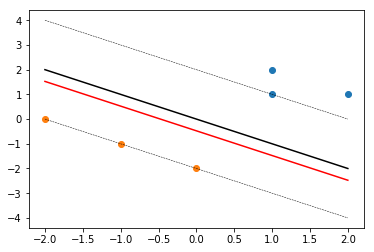

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

X = np.array([[1,2],[1,1],[2,1], [-2,0], [-1,-1], [0,-2]])
Y = np.array([0,0,0,1,1,1])

plt.scatter(X[Y==0,0], X[Y==0,1])
plt.scatter(X[Y==1,0], X[Y==1,1])

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X,Y)

x = np.linspace(np.int(np.min(X[:,0])), np.int(np.max(X[:,1])),100)
y = -(x*clf.coef_[0,0] + clf.intercept_ -0.5)/clf.coef_[0,1] 
plt.plot(x,y, color='red') 

y2 = -x
plt.plot(x,y2, color='black') 
y21 = -x+2
plt.plot(x,y21, color='black', linestyle='--', linewidth=0.5) 
y22 = -x - 2
plt.plot(x,y22, color='black', linestyle='dashed', linewidth=0.5) 

Zapewnienie maksymalnego marginesu wokół prostej separującej dwa zbiory próbek daje klasyfikatorowi największe szanse poprawnego działania w konfrontacji z nieznanymi wcześniej, być może, trudniejszymi próbkami rozważanych klas. Dlatego też, celem prac, których efektem było opracowanie metody SVM stało się znalezienie sposobu wyznaczania takiej powierzchni separującej dwa liniowo-separowalne zbiory, która zapewnia maksymalną szerokość marginesu (w 2D można to okreśilć jako znalezienie najszerszej 'drogi', której osią jest separująca prosta, a na poboczu lewym i prawym znajdują się punkty obydwu klas).

### Szerokość bufora
Aby określić szerokość pasa wokół linii separującej zbiory (dla 2D) załóżmy, że na jej jednym brzegu znajduje się punkt jednej klasy (oznaczmy go jako $\mathbf{x}_-$, zaś na drugim - punkt drugiej klasy ($\mathbf{x}_+$). Szerokość pasa $d$ to długość rzutu wektora $\mathbf{\Delta x} = \mathbf{x}_+ - \mathbf{x}_-$ na wektor jednostkowy prostopadły do linii (dla linii $w_1x + w_2y + b = 0$ jest to wektor $\mathbf{w}=[w_1,w_2]$), a ponieważ rzut to iloczyn skalarny, więc:
\begin{equation}
d = \mathbf{\Delta x}^T \frac{\mathbf{w}}{||\mathbf{w}||}= (\mathbf{x}_+ - \mathbf{x}_-)^T \frac{\mathbf{w}}{||\mathbf{w}||}
\end{equation}
Punkty $\mathbf{x}_+$ i  $\mathbf{x}_-$ leżą w jednakowej odległości od poszukiwanej linii. Oznacza to, że jeśli dla punktu $\mathbf{x}_+$ leżącego po 'dodatniej' stronie prostej $w_1x + w_2y + b = 0$  zachodzi zależność $\mathbf{w}^T \mathbf{x}_+ + b = a$, to dla punktu leżącego po 'ujemnej' stronie prostej, zachodzi zależność: $ \mathbf{w}^T \mathbf{x}_+ + b = -a$, więc przyjmując, że $a=1$:
\begin{equation}
d = \frac{\mathbf{w}^T\mathbf{x}_+ - \mathbf{w}^T\mathbf{x}_-)}{||\mathbf{w}||} = \frac{1-b -(-1-b)}{||\mathbf{w}||} = \frac{2}{||\mathbf{w}||}
\end{equation}


### Kryterium wyboru hiperpłaszczyzny

Wnioskiem z przeprowadzanej analizy jest stwierdzenie, że szerokość pasa jest odwrotnie proporcjonalna do normy wektora hiperpłaszczyzny, czyli przedmiotem poszukiwań będzie hiperpłaszczyzna o minimalnej normie $\mathbf{w}$. Naturalnie, hiperpłaszczyzna ta musi spełniać jeszcze dodatkowe warunki (wybór jako funkcji kryterialnej wyłącznie warunku minimalizacji $||\mathbf{w}||$ nie ma sensu, bo wynikiem będzie $||\mathbf{w}||=0$, a co więcej, funkcja kryterialna w żaden sposób nie odnosi się do posiadanych danych). Te dodatkowe warunki to konieczność zapewnienia, by dla punktów leżących na 'poboczu' pasa zachodziło: $\mathbf{w}^T \mathbf{x}_+ + b = 1$ lub $\mathbf{w}^T \mathbf{x}_- + b = -1$, w zależności od etykiety punktu ($y_i(\mathbf{x}_i) = 1$ gdy $\mathbf{x}_i = \mathbf{x}_+$, zaś $y_i(\mathbf{x}_i) = -1$ gdy $\mathbf{x}_i = \mathbf{x}_-$). Oydwa wymagania: zapewnienie maksymalnej szerokości pasa i zapewnienie, by próbki 'pobocza' spełniały przedstawione warunki stanowią treść kryterium wyboru optymalnej hiperpłaszczyzny. Cel główny procedury to znalezienie takiego wektora $\mathbf{w}$, który buduje najszerszy pas:
\begin{equation}
\mathbf{w}^* = \arg \min_\mathbf{w} \frac{||\mathbf{w}||}{2} \equiv \arg \min_\mathbf{w} \frac{\mathbf{w}^T \mathbf{w}}{2}
\end{equation}
Warunki, które jednocześnie muszą być spełnione to zapewnienie dla próbek leżących na skraju pasa by:
\begin{equation}
\mathbf{w}^T \mathbf{x}_i + b = 
\left\{ 
\begin{array}{ccc}
=1 & \rightarrow & y_i(\mathbf{x}_i = \mathbf{x}_+) =1 \\
=-1 & \rightarrow & y_i(\mathbf{x}_i = \mathbf{x}_-) = -1
\end{array}
\right.
\end{equation}
Obydwa warunki te można przedstawić w zwartej postaci:
\begin{equation}
y_i(\mathbf{w}^T\mathbf{x}_i +b) = 1
\end{equation}
Przedstawiony problem optymalizacji z ograniczeniami w formie zbioru równań można przekształcić do problemu optymalizacji bez ograniczeń, wykorzystując metodę współczynników Lagrange'a. Odpowiednia funkcja kryterialna, zawierająca w sobie zarówno cel jak i ograniczenia (funkcja Lagrange'a) ma postać:
\begin{equation}
\mathcal{L} (\mathbf{w}, b, \lambda_1 ... \lambda_n) = \frac{\mathbf{w}^T \mathbf{w}}{2} - \sum_{i=1}^n \lambda_i [y_i(\mathbf{w}^T\mathbf{x}_i +b) - 1]
\end{equation}
Funkcja ta ma zostać poddana minimalizacji z punktu widzenia parametrów $\mathbf{w}, b i \lambda_i$, przy czym dziedziną poszukiwań w odniesieniu do parametrów hiperpłaszczyzny jest przestrzeń liczb rzeczywistych, natomiast współczynniki Lagrange'a muszą być nieujemne ($\forall_i \hspace{0.2cm} \lambda_i \ge 0 $). Warunkiem koniecznym istnienia ekstremum w odniesieniu do parametrów hiperpłaszczyzny jest zerowanie się pochodnych, czyli:
\begin{equation}
\left[
\begin{array}{c}
\frac{\partial \mathcal{L}(.)}{\partial \mathbf{w}} \\
\frac{\partial \mathcal{L}(.)}{\partial \mathbf{b}} 
\end{array}
\right] = \left[
\begin{array}{c}
0 \\
0 
\end{array}
\right]
\end{equation}
Wyznaczając wartości pochodnych, uzyskujemy:
\begin{equation}
\frac{\partial \mathcal{L}(.)}{\partial \mathbf{w}} = \mathbf{w} + \sum_i \lambda_i y_i \mathbf{x}_i = 0 \rightarrow \mathbf{w} = \sum_i \lambda_i y_i \mathbf{x}_i
\end{equation}
oraz:
\begin{equation}
\frac{\partial \mathcal{L}(.)}{\partial b} =  \sum_i \lambda_i y_i  = 0 
\end{equation}
Pierwszym wnioskiem z przeprowadzonej analizy jest to, że poszukiwany wektor parametrów hiperpłaszczyzny to liniowa kombinacja próbek treningowych (współczynniki tej kombinacji to, nieznane jeszcze, wartości $\lambda_i$). Reguła decyzyjna klasyfikacji punktu $\mathbf{x} $ to sprawdzenie znaku wyrażenia: 
\begin{equation}
f( \mathbf{x}) = \mathbf{w}^T \mathbf{x} +b  =  \sum_i \lambda_i y_i \mathbf{x}_i^T \mathbf{x} + b
\end{equation}

Wstawiając do funkcji Lagrange'a wyznaczone warunki, uzyskujemy jej postać, w której jedyną niewiadomą są wartości współczynników Lagrange'a:
\begin{equation}
\mathcal{L}( \boldsymbol{\lambda}) =  \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \lambda_i \lambda_j y_i y_j \mathbf{x}_i^T\mathbf{x}_j - \sum_{i=1}^n \sum_{j=1}^n \lambda_i \lambda_j y_i y_j \mathbf{x}_i^T\mathbf{x}_j - b\cdot 0 + \sum_{i=1}^n \lambda_i = \sum_{i=1}^n \lambda_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \lambda_i \lambda_j y_i y_j \mathbf{x}_i^T\mathbf{x}_j
\end{equation}

Współczynniki Lagrange'a muszą być nieujemne, dlatego też w celu znalezienia ekstremum funkcji względem $\lambda_i$ nie można przyrównać pochodnej powyższego wyrażenia do zera (bo uzyskane wyniki mogłyby być ujemne), więc w celu rozwiązania zadania konieczne jest zastosowanie metod optymalizacji (tzw. programowania kwadratowego, gdzie problem to funkcja kwadratowa, a ograniczenia mają postać nierówności i równania $\sum_i \lambda_i y_i  = 0$). W wyniku wykonania odpowiednich obliczeń, zwracany jest wektor współczynników Lagrange'a, przy czym wszystkie wartości współczynników odpowiadające próbkom położonym poza 'poboczem' będą równe zeru (niezerowe zostaną tylko te, które dotyczą próbek położonych na marginesie pasa). 

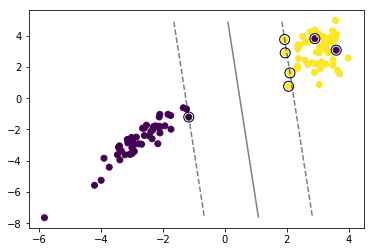

In [2]:
# Przykład: trening liniowego klasyfikatora SVM 
import matplotlib.pyplot as plt
# Funkcja do generacji zbioru przykładów dla celów klasyfikacji
from sklearn.datasets import make_classification
%matplotlib inline
import numpy as np

X, Y = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1,
                            class_sep = 3) 
plt.scatter(X[:, 0], X[:, 1], c=Y)

from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X,Y)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
h = (x_max - x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xy = np.vstack([xx.ravel(), yy.ravel()]).T
Z = clf.decision_function(xy).reshape(xx.shape)

# plot decision boundary and margins
ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

## Nieliniowe powierzchnie separujące o maksymalnym marginesie

Przedstawiony sposób określania powierzchni decyzyjnej o największym marginesie zapewnia największą możliwą tolerancję na pojawianie się w czasie pracy klasyfikatora próbek 'trudnych', ale zakłada liniową separowalność zbiorów rozważanych klas. Ponieważ problemy, w których klasy sa liniowo-separowalne są problemami prostymi, metoda SVM nie odegrałaby istotnej roli w uczeniu maszynowym, gdyby nie oferowana przez nią możliwość uogólnienia do postaci, w której pozwala ona na budowanie dowolnie skomplikowanych powierzchni decyzyjnych, charakteryzujących się maksymalnym możliwym marginesem. 

### Transformacje do przestrzeni wielkowymiarowej

Rozważmy próbki określone w przestrzeni 1D, należące do dwóch klas nieseparowalnych liniowo, przedstawione poniżej. Jeżeli dokonamy ich odpoiedniej transformacji do przestrzeni 2D, np.:
\begin{equation}
\mathbf{x}^{2D} = \Phi (\mathbf{x}^{1D})= \Phi (x_1]) = \left[ 
\begin{array}{c}
x_1 \\
x_1^2
\end{array}
\right]
\end{equation}
Problem staje się liniowo separowalny. Transformacja do przestrzeni o większej liczbie wymiarów może więc być uznana za sposób przekształcenia problemu liniowo nieseparowalnego do problemu liniowo separowalnego, który może zostać rozwiązany z wykorzystaniem liniowych funkcji separacji, w szczególności, przedstawioną liniową metodą SVM.

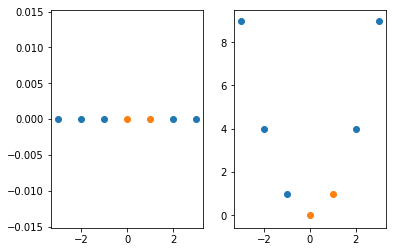

In [13]:
X1D = np.arange(7) - 3
Y1 = np.zeros(X1D.shape)
Y1[3:5] = 1
plt.subplot(1,2,1)
plt.scatter(X1D[Y1==0],np.zeros(5))
plt.scatter(X1D[Y1==1],np.zeros(2))
X2D = np.array([X1D,X1D*X1D])
plt.subplot(1,2,2)
plt.scatter(X2D[0,Y1==0],X2D[1,Y1==0])
plt.scatter(X2D[0,Y1==1],X2D[1,Y1==1])

Zarówno trening klasyfikatora SVM jak i reguła podejmowania decyzji korzysta z iloczynów skalarnych. W przedstawionych równaniach są to iloczyny $\mathbf{x}_i^T \mathbf{x}_j$ dla treningu (występujące w funkcji Lagrange'a) i $\mathbf{x}_i^T \mathbf{x}$ (w regule decyzyjnej), gdzie $\mathbf{x}_i, \mathbf{x}_j$ to próbki treningowe, zaś $\mathbf{x}$ to próbka poddawana klasyfikacji. Jeżeli próbki zostaną przekształcone do przestrzeni o większej liczbie wymiarów za pomocą transformacji $\Phi(.)$, wtedy trening i klasyfikacja SVM w tej nowej przestrzeni też będzie korzystać z iloczynów skalarnych, tym razem wektorów $\Phi(\mathbf{x}_i)^T \Phi (\mathbf{x}_j)$ i $\Phi(\mathbf{x}_i)^T \Phi (\mathbf{x})$. Dlatego też, SVM może być wykorzystane do rozwiązywania problemów liniowo nieseparowalnych: próbki są transformowane do przestrzeni o wyższej wymiarowości, gdzie budowany jest klasyfikator i podejmowana jest odpowiednia decyzja.

### Funkcje jądra

Problemem pojawiającym się w próbie realizacji przedstawionego powyżej pomysłu jest możliwy, bardzo duży wymiar przestrzeni, zapewniającej liniową separację rzutów próbek, uniemożliwiający praktyczną realizację obliczeń (wymagana przestrzeń może być nieskończenie wymiarowa, może mieć miliony wymiarów itp.). Rozwiązaniem tego problemu jest spostrzeżenie, że iloczyny skalarne między rzutami próbek mogą być wyrażone za pomocą odpowiednich funkcji, nazywanych funkcjami jądra (ang. kernels) operujących na próbkach oryginalnych. 

#### Przykład

Załóżmy, że dana jest funkcja $k(\mathbf{x},\mathbf{y}) = ( \mathbf{x}^T \mathbf{y})^2$ i że wektory są dwuwymiarowe. Wynik obliczenia wartości funkcji:
\begin{equation}
k(\mathbf{x},\mathbf{y}) = \left( [x_1, x_2] \left[ 
\begin{array}{c}
y_1 \\
y_2
\end{array}
\right] \right)^2 = (x_1 y_1 + x_2 y_2 )^2 = (x_1 y_1)^2 + x_1y_1 x_2 y_2 + (x_2 y_2)^2
\end{equation}

można wyrazić jako iloczyn skalarny dwóch wektorów $\mathbf{X} = \Phi(\mathbf{x})$ i $\mathbf{Y} = \Phi(\mathbf{y})$, okreslonych w przestrzeni trójwymiarowej:
\begin{equation}
\mathbf{X}^T\mathbf{Y} = [(x_1)^2, x_1 x_2,  (x_2)^2] \left[ 
\begin{array}{c}
(y_1)^2 \\
y_1  y_2 \\
(y_2)^2 
\end{array}
\right] 
\end{equation}

Oznacza to, że realizacja klasyfikacji SVM w przestrzeni 3D nie wymaga jawnego rzutowania wektorów - zarówno problem wyboru hiperpłaszczyzny, jak i podejmowanie decyzji, mogą być rozwiązane poprzez zastąpienie iloczynów skalarnych rzutów próbek do przestrzeni wysokowymiarowej za pomocą funkcji jądra $k(\mathbf{x},\mathbf{y})$, operującej na próbkach w przestrzeni oryginalnej:
\begin{equation}
\mathcal{L}( \boldsymbol{\lambda}) =  \sum_{i=1}^n \lambda_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \lambda_i \lambda_j y_i y_j \Phi(\mathbf{x}_i)^T \Phi(\mathbf{x}_j) = \sum_{i=1}^n \lambda_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \lambda_i \lambda_j y_i y_j k(\mathbf{x}_i,\mathbf{x}_j) 
\end{equation}
dla treningu klasyfikatora, i:
\begin{equation}
f( \mathbf{x}) = \sum_i \lambda_i y_i \Phi(\mathbf{x}_i)^T \Phi(\mathbf{x}) + b = \sum_i \lambda_i y_i k(\mathbf{x}_i, \mathbf{x}) + b
\end{equation}
dla podejmowania decyzji. 


Teoretyczne prace nad funkcjami jądra, czyli funkcjami zapewniającymi efekty działania równoważne iloczynom skalarnym próbek transformowanych do wysokowymiarowych przestrzeni, doprowadziła do określenia szeregu postaci tych funkcji, z których najpowszechniej dzisiaj stosowanymi są funkcje jądra wielomianowe, o postaci:
\begin{equation}
k(\mathbf{x}_i, \mathbf{x}) = (\mathbf{x}^T \mathbf{y} +1)^n
\end{equation}
funkcje radialne:
\begin{equation}
k(\mathbf{x}_i, \mathbf{x}) = f(|| \mathbf{x} - \mathbf{y} ||)
\end{equation}

i funkcje sigmoidalne:
\begin{equation}
k(\mathbf{x}_i, \mathbf{x}) = \frac{1}{1+ e^{-\mathbf{x}^T \mathbf{y} } }
\end{equation}


Liczba wymiarów 'niejawnej' przestrzeni, zastępowanej przez funkcje jądra może być nieskończenie wielka (dla funkcji radialnych i sigmoidalnych). Dla 'kerneli' wielomianowych, jest ona bardzo szybko rosnącą funkcją liczby wymiarów oryginalnej przestrzeni cech i potęgi wielomianu.

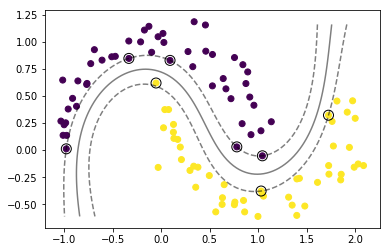

In [10]:
# nieliniowe powierzchnie separujące
from sklearn.datasets import make_moons, make_circles

XM, YM = make_moons(noise = 0.1) # noise 0....1 - zaburzenie
plt.scatter(XM[:, 0], XM[:, 1], c=YM)
#XC, YC = make_circles(noise = 0.1, factor=0.5) # factor = wsp między promieniami wewn. i zewn. (0< ... <1)
#plt.scatter(XC[:, 0], XC[:, 1], c=YC)

clf = svm.SVC(C=100.0) # parametr C określa tolerancję na możliwie błędną klasyfikację próbek
clf.fit(XM,YM)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

x_min, x_max = XM[:, 0].min(), XM[:, 0].max()
y_min, y_max = XM[:, 1].min(), XM[:, 1].max()
h = (x_max - x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xy = np.vstack([xx.ravel(), yy.ravel()]).T
Z = clf.decision_function(xy).reshape(xx.shape)

# plot decision boundary and margins
ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

## Podsumowanie

Metoda SVM zapewnia realizację dwóch niezwykle ważnych wymagań stawianych przed metodami klasyfikacji i regresji przez problemy rzeczywiste:
- możliwość prawidłowej reprezentacji zbiorów o dowolnej geometrii ich granic
- zapewnienie maksymalnej możliwej tolerancji na odstępstwa analizowanych próbek od wartości dysponowanych w zbiorze przykładów (który jest tylko wycinkiem całej populacji)

Z tych powodów, SVM uważana była długo przez najlepszą możliwą strategię uczenia maszynowego. Gdyby możliwe było zapewnienie klasom, rozważanym w analizie, właściwej reprezentacji ilościowej, uwzględniającej wszystkie istotne dla klasy właściwości, prawdopodobnie byłaby metodą wystarczającą z punktu widzenia zastosować praktycznych. Niestety, stosowane metody ekstrakcji cech (np. PCA) okazują się niedostatecznie silne, skutkując silnym przemieszaniem próbek różnych klas, co sprawia, że uzyskiwane przez SVM wyniki mogą być niewystarczające z powodu nadmiernego skomplikowania powierzchni decyzyjnych.

### Materiały dodatkowe



#### Odległość punktu od hiperpłaszczyzny

Załóżmy, że dana jest hiperpłaszczyzna o równaniu $\mathbf{w}^T \mathbf{x} + C = 0$ ($w_1x_1 + w_2 x_2 + ... + C = 0$), oraz że dany jest punkt $\mathbf{P} = [P_1, P_2 ...]$. Odległość punktu od hiperpłaszczyzny to:
\begin{equation} 
d = || \mathbf{PQ} || \cos \theta ,
\end{equation} 
gdzie ||.|| oznacza długość wektora $\mathbf{PQ} = [P_1-Q_1, P_2 - Q_2, ...]$, którego jednym końcem jest $\mathbf{P}$, drugim $\mathbf{Q}$ (dowolny punkt na hiperpłaszczyźnie), a $\theta$ to kąt między wektorem $\mathbf{PQ}$ a wektorem normalnym do hiperpłaszczyzny, czyli wektorem $\mathbf{w}$. Jeżeli pomnożymy i podzielimy wyrażenie na odległość przez długość wektora hiperpłaszczyzny:
\begin{equation} 
d = \frac{||\mathbf{PQ}|| \hspace{0.2cm} ||\mathbf{w}|| \cos \theta}{||\mathbf{w}||} ,
\end{equation} 
to w liczniku uzyskamy iloczyn skalarny wektorów, czyli:
\begin{equation} 
L = \mathbf{PQ}^T \mathbf{w} = w_1(P_1-Q_1) + w_2(P_2 - Q_2) + ...,
\end{equation} 
Po uporządkowaniu, wyrażenie to można wyrazić jako:
\begin{equation} 
L = w_1P_1 - w_1 Q_1 + w_2 P_2 - w_2 Q_2 + ... = w_1 P_1 + w_2 P_2 + ... - (w_1 Q_1 + w_2 Q_2 + ...) = w_1 P_1 + w_2 P_2 + ...  + C,
\end{equation}
Tak więc odległość punktu od hiperpłaszczyzny wynosi:
\begin{equation} 
d = \frac{||w_1 P_1 + w_2 P_2 + ...  + C||}{||\mathbf{w}||} = \frac{||w_1 P_1 + w_2 P_2 + ...  + C||}{\sqrt{ \sum_i w_i^2}}
\end{equation} 

